In [88]:
%load_ext autoreload
%autoreload 2

import math
import copy
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.datasets import *
from torchvision.transforms import *
from torch.utils.data import DataLoader
from utils import *
from model import *
from evaluation import *
from train import *
from pruning import *
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset Preparation

In [3]:
CIFAR10.url="https://data.brainchip.com/dataset-mirror/cifar10/cifar-10-python.tar.gz"

image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


### Prepare the model

In [93]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url, model_dir="model_dir"), map_location="cpu")
model = VGG().to(DEVICE)
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [5]:
dense_model_accuracy = evaluate(model, dataloader['test'], device=DEVICE)
dense_model_size = get_model_size(model)

In [6]:
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense model has accuracy=92.95%
dense model has size=35.20 MiB


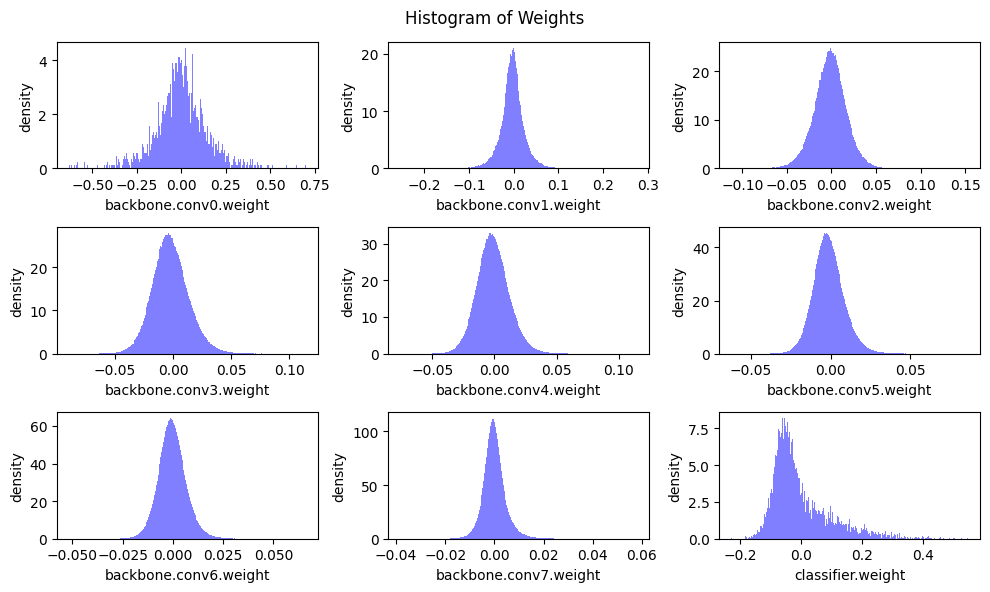

In [80]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

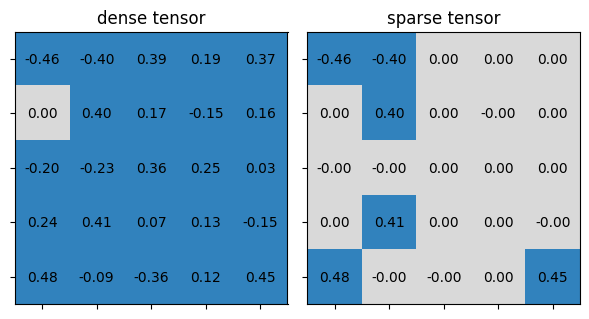

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [54]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')
test_fine_grained_prune()

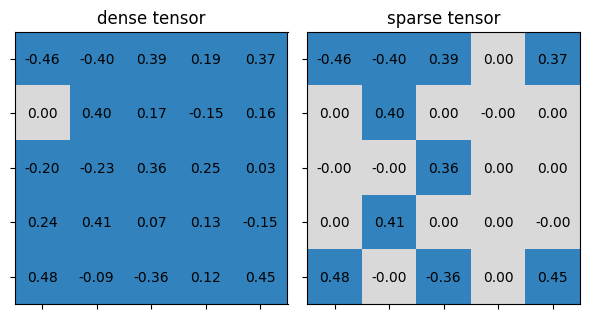

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [56]:
target_sparsity = 0.6
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

### Sensivity Scan

In [61]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, device=DEVICE, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [81]:
sparsities, accuracies = sensitivity_scan(model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:  17%|█▋        | 1/6 [00:01<00:09,  1.91s/it]

    sparsity=0.40: accuracy=92.42%

scanning 0/9 weight - backbone.conv0.weight:  33%|███▎      | 2/6 [00:03<00:07,  1.81s/it]

    sparsity=0.50: accuracy=91.19%

scanning 0/9 weight - backbone.conv0.weight:  50%|█████     | 3/6 [00:05<00:05,  1.77s/it]

    sparsity=0.60: accuracy=87.55%

scanning 0/9 weight - backbone.conv0.weight:  67%|██████▋   | 4/6 [00:07<00:03,  1.76s/it]

    sparsity=0.70: accuracy=83.39%

scanning 0/9 weight - backbone.conv0.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.75s/it]

    sparsity=0.80: accuracy=69.43%

scanning 0/9 weight - backbone.conv0.weight: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.43%, 31.82%]

scanning 1/9 weight - backbone.conv1.weight:  17%|█▋        | 1/6 [00:01<00:08,  1.75s/it]

    sparsity=0.40: accuracy=92.93%

scanning 1/9 weight - backbone.conv1.weight:  33%|███▎      | 2/6 [00:03<00:07,  1.75s/it]

    sparsity=0.50: accuracy=92.88%

scanning 1/9 weight - backbone.conv1.weight:  50%|█████     | 3/6 [00:05<00:05,  1.76s/it]

    sparsity=0.60: accuracy=92.71%

scanning 1/9 weight - backbone.conv1.weight:  67%|██████▋   | 4/6 [00:07<00:03,  1.76s/it]

    sparsity=0.70: accuracy=92.40%

scanning 1/9 weight - backbone.conv1.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.76s/it]

    sparsity=0.80: accuracy=91.32%

scanning 1/9 weight - backbone.conv1.weight: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:  17%|█▋        | 1/6 [00:01<00:08,  1.74s/it]

    sparsity=0.40: accuracy=92.94%

scanning 2/9 weight - backbone.conv2.weight:  33%|███▎      | 2/6 [00:03<00:07,  1.75s/it]

    sparsity=0.50: accuracy=92.64%

scanning 2/9 weight - backbone.conv2.weight:  50%|█████     | 3/6 [00:05<00:05,  1.75s/it]

    sparsity=0.60: accuracy=92.46%

scanning 2/9 weight - backbone.conv2.weight:  67%|██████▋   | 4/6 [00:07<00:03,  1.76s/it]

    sparsity=0.70: accuracy=91.77%

scanning 2/9 weight - backbone.conv2.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.76s/it]

    sparsity=0.80: accuracy=89.85%

scanning 2/9 weight - backbone.conv2.weight: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:  17%|█▋        | 1/6 [00:01<00:08,  1.74s/it]

    sparsity=0.40: accuracy=92.86%

scanning 3/9 weight - backbone.conv3.weight:  33%|███▎      | 2/6 [00:03<00:06,  1.73s/it]

    sparsity=0.50: accuracy=92.72%

scanning 3/9 weight - backbone.conv3.weight:  50%|█████     | 3/6 [00:05<00:05,  1.73s/it]

    sparsity=0.60: accuracy=92.23%

scanning 3/9 weight - backbone.conv3.weight:  67%|██████▋   | 4/6 [00:06<00:03,  1.73s/it]

    sparsity=0.70: accuracy=91.09%

scanning 3/9 weight - backbone.conv3.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.73s/it]

    sparsity=0.80: accuracy=85.35%

scanning 3/9 weight - backbone.conv3.weight: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.29%]

scanning 4/9 weight - backbone.conv4.weight:  17%|█▋        | 1/6 [00:01<00:08,  1.75s/it]

    sparsity=0.40: accuracy=92.88%

scanning 4/9 weight - backbone.conv4.weight:  33%|███▎      | 2/6 [00:03<00:06,  1.75s/it]

    sparsity=0.50: accuracy=92.68%

scanning 4/9 weight - backbone.conv4.weight:  50%|█████     | 3/6 [00:05<00:05,  1.74s/it]

    sparsity=0.60: accuracy=92.22%

scanning 4/9 weight - backbone.conv4.weight:  67%|██████▋   | 4/6 [00:06<00:03,  1.74s/it]

    sparsity=0.70: accuracy=89.47%

scanning 4/9 weight - backbone.conv4.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.73s/it]

    sparsity=0.80: accuracy=76.86%

scanning 4/9 weight - backbone.conv4.weight: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:  17%|█▋        | 1/6 [00:01<00:08,  1.73s/it]

    sparsity=0.40: accuracy=92.92%

scanning 5/9 weight - backbone.conv5.weight:  33%|███▎      | 2/6 [00:03<00:06,  1.74s/it]

    sparsity=0.50: accuracy=92.71%

scanning 5/9 weight - backbone.conv5.weight:  50%|█████     | 3/6 [00:05<00:05,  1.74s/it]

    sparsity=0.60: accuracy=92.64%

scanning 5/9 weight - backbone.conv5.weight:  67%|██████▋   | 4/6 [00:06<00:03,  1.74s/it]

    sparsity=0.70: accuracy=91.88%

scanning 5/9 weight - backbone.conv5.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.73s/it]

    sparsity=0.80: accuracy=89.90%

scanning 5/9 weight - backbone.conv5.weight: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.64%, 91.88%, 89.90%, 82.21%]

scanning 6/9 weight - backbone.conv6.weight:  17%|█▋        | 1/6 [00:01<00:08,  1.73s/it]

    sparsity=0.40: accuracy=92.95%

scanning 6/9 weight - backbone.conv6.weight:  33%|███▎      | 2/6 [00:03<00:06,  1.72s/it]

    sparsity=0.50: accuracy=92.86%

scanning 6/9 weight - backbone.conv6.weight:  50%|█████     | 3/6 [00:05<00:05,  1.72s/it]

    sparsity=0.60: accuracy=92.65%

scanning 6/9 weight - backbone.conv6.weight:  67%|██████▋   | 4/6 [00:06<00:03,  1.72s/it]

    sparsity=0.70: accuracy=92.10%

scanning 6/9 weight - backbone.conv6.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.72s/it]

    sparsity=0.80: accuracy=90.58%

scanning 6/9 weight - backbone.conv6.weight: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.86%, 92.65%, 92.10%, 90.58%, 83.64%]

scanning 7/9 weight - backbone.conv7.weight:  17%|█▋        | 1/6 [00:01<00:08,  1.72s/it]

    sparsity=0.40: accuracy=92.93%

scanning 7/9 weight - backbone.conv7.weight:  33%|███▎      | 2/6 [00:03<00:06,  1.72s/it]

    sparsity=0.50: accuracy=92.90%

scanning 7/9 weight - backbone.conv7.weight:  50%|█████     | 3/6 [00:05<00:05,  1.73s/it]

    sparsity=0.60: accuracy=92.89%

scanning 7/9 weight - backbone.conv7.weight:  67%|██████▋   | 4/6 [00:06<00:03,  1.72s/it]

    sparsity=0.70: accuracy=92.81%

scanning 7/9 weight - backbone.conv7.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.71s/it]

    sparsity=0.80: accuracy=92.63%

scanning 7/9 weight - backbone.conv7.weight: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.90%, 92.89%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:  17%|█▋        | 1/6 [00:01<00:08,  1.69s/it]

    sparsity=0.40: accuracy=92.91%

scanning 8/9 weight - classifier.weight:  33%|███▎      | 2/6 [00:03<00:06,  1.69s/it]

    sparsity=0.50: accuracy=92.83%

scanning 8/9 weight - classifier.weight:  50%|█████     | 3/6 [00:05<00:05,  1.69s/it]

    sparsity=0.60: accuracy=92.82%

scanning 8/9 weight - classifier.weight:  67%|██████▋   | 4/6 [00:06<00:03,  1.69s/it]

    sparsity=0.70: accuracy=92.96%

scanning 8/9 weight - classifier.weight:  83%|████████▎ | 5/6 [00:08<00:01,  1.69s/it]

    sparsity=0.80: accuracy=92.67%

scanning 8/9 weight - classifier.weight: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.82%, 92.96%, 92.67%, 92.52%]

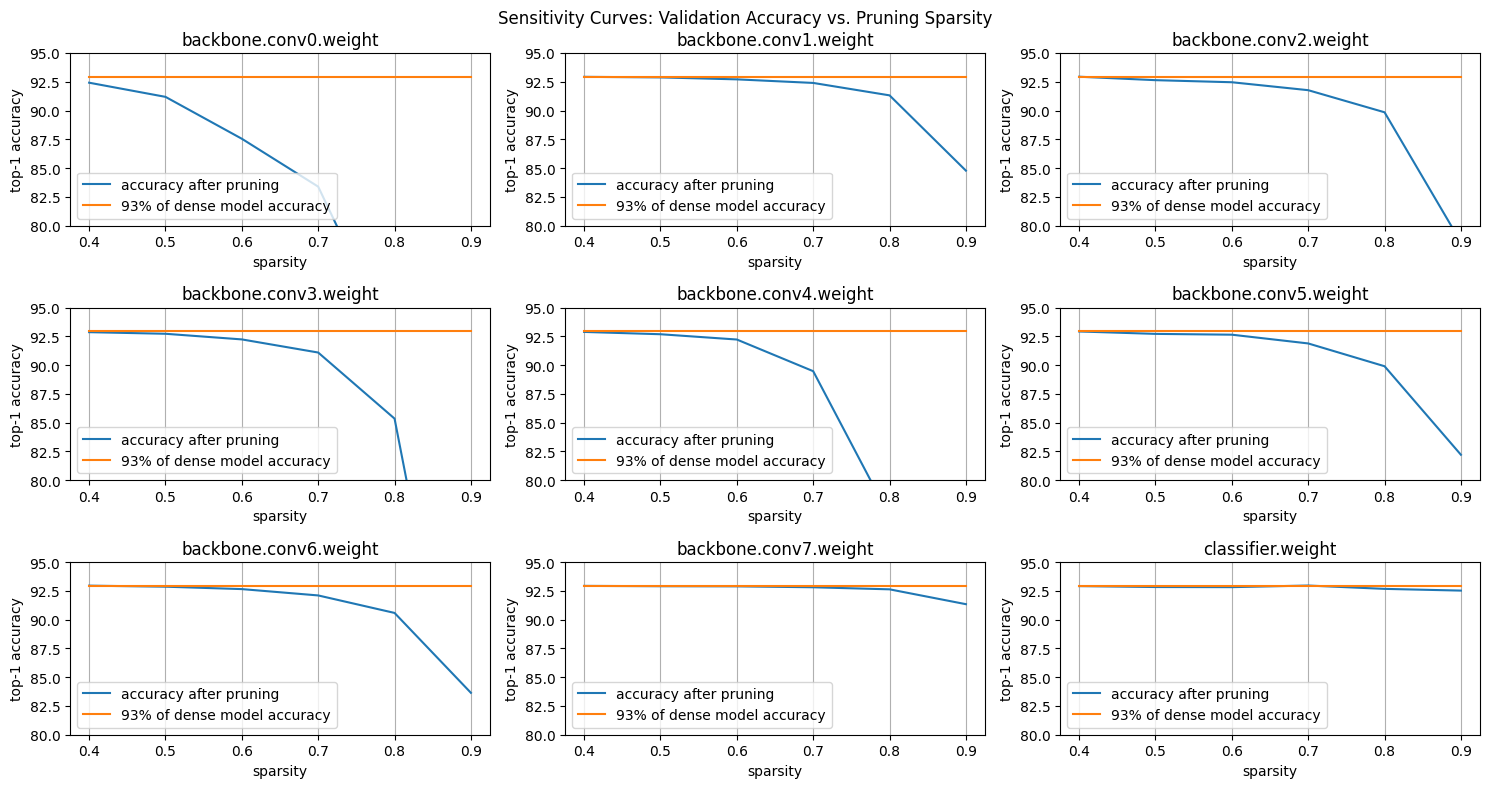

In [86]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [dense_model_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{dense_model_accuracy:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

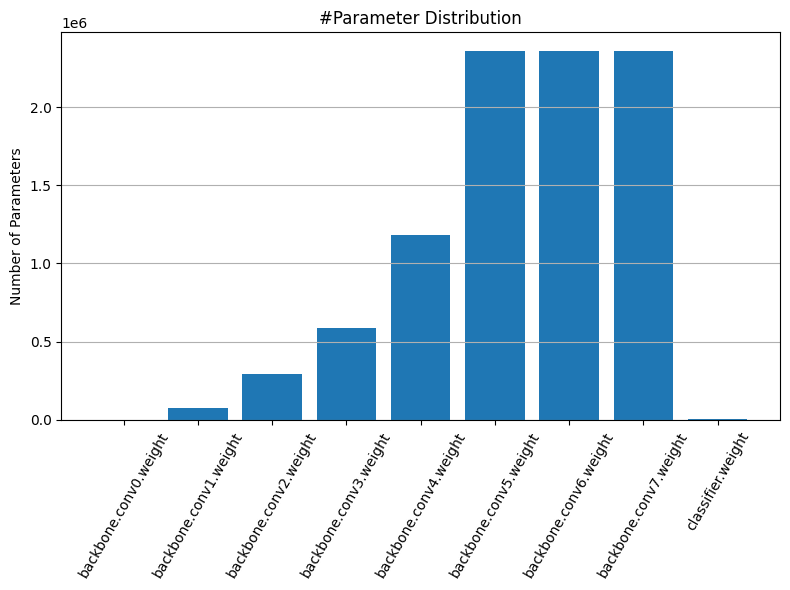

In [87]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

### Find the optimal sparsities and finetune the model

In [7]:
optimal_sparsities, sparsities, accuracies = get_optimal_sparsities(model,
                                                                    dataloader['test'], 
                                                                    scan_step=0.1, 
                                                                    scan_start=0.0, 
                                                                    scan_end=1.0,
                                                                    sparsity_thr=0.1,
                                                                    device=DEVICE,
                                                                    verbose=True,
                                                                    return_accuracies_sparsities=True)

scanning 0/9 weight - backbone.conv0.weight:  10%|█         | 1/10 [00:01<00:15,  1.70s/it]

    sparsity=0.00: accuracy=92.95%

scanning 0/9 weight - backbone.conv0.weight:  20%|██        | 2/10 [00:03<00:13,  1.73s/it]

    sparsity=0.10: accuracy=92.92%

scanning 0/9 weight - backbone.conv0.weight:  30%|███       | 3/10 [00:05<00:12,  1.72s/it]

    sparsity=0.20: accuracy=92.96%

scanning 0/9 weight - backbone.conv0.weight:  40%|████      | 4/10 [00:06<00:10,  1.71s/it]

    sparsity=0.30: accuracy=92.60%

scanning 0/9 weight - backbone.conv0.weight:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

    sparsity=0.40: accuracy=92.42%

scanning 0/9 weight - backbone.conv0.weight:  60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

    sparsity=0.50: accuracy=91.19%

scanning 0/9 weight - backbone.conv0.weight:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

    sparsity=0.60: accuracy=87.55%

scanning 0/9 weight - backbone.conv0.weight:  80%|████████  | 8/10 [00:13<00:03,  1.67s/it]

    sparsity=0.70: accuracy=83.39%

scanning 0/9 weight - backbone.conv0.weight:  90%|█████████ | 9/10 [00:15<00:01,  1.66s/it]

    sparsity=0.80: accuracy=69.43%

scanning 0/9 weight - backbone.conv0.weight: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.92%, 92.96%, 92.60%, 92.42%, 91.19%, 87.55%, 83.39%, 69.43%, 31.82%]

scanning 1/9 weight - backbone.conv1.weight:  10%|█         | 1/10 [00:01<00:14,  1.63s/it]

    sparsity=0.00: accuracy=92.95%

scanning 1/9 weight - backbone.conv1.weight:  20%|██        | 2/10 [00:03<00:13,  1.64s/it]

    sparsity=0.10: accuracy=92.94%

scanning 1/9 weight - backbone.conv1.weight:  30%|███       | 3/10 [00:04<00:11,  1.64s/it]

    sparsity=0.20: accuracy=92.91%

scanning 1/9 weight - backbone.conv1.weight:  40%|████      | 4/10 [00:06<00:09,  1.64s/it]

    sparsity=0.30: accuracy=92.97%

scanning 1/9 weight - backbone.conv1.weight:  50%|█████     | 5/10 [00:08<00:08,  1.64s/it]

    sparsity=0.40: accuracy=92.93%

scanning 1/9 weight - backbone.conv1.weight:  60%|██████    | 6/10 [00:09<00:06,  1.67s/it]

    sparsity=0.50: accuracy=92.88%

scanning 1/9 weight - backbone.conv1.weight:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]

    sparsity=0.60: accuracy=92.71%

scanning 1/9 weight - backbone.conv1.weight:  80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

    sparsity=0.70: accuracy=92.40%

scanning 1/9 weight - backbone.conv1.weight:  90%|█████████ | 9/10 [00:14<00:01,  1.63s/it]

    sparsity=0.80: accuracy=91.32%

scanning 1/9 weight - backbone.conv1.weight: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.94%, 92.91%, 92.97%, 92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:  10%|█         | 1/10 [00:01<00:14,  1.59s/it]

    sparsity=0.00: accuracy=92.95%

scanning 2/9 weight - backbone.conv2.weight:  20%|██        | 2/10 [00:03<00:12,  1.60s/it]

    sparsity=0.10: accuracy=92.94%

scanning 2/9 weight - backbone.conv2.weight:  30%|███       | 3/10 [00:04<00:11,  1.60s/it]

    sparsity=0.20: accuracy=92.95%

scanning 2/9 weight - backbone.conv2.weight:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]

    sparsity=0.30: accuracy=92.94%

scanning 2/9 weight - backbone.conv2.weight:  50%|█████     | 5/10 [00:07<00:07,  1.60s/it]

    sparsity=0.40: accuracy=92.94%

scanning 2/9 weight - backbone.conv2.weight:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]

    sparsity=0.50: accuracy=92.64%

scanning 2/9 weight - backbone.conv2.weight:  70%|███████   | 7/10 [00:11<00:04,  1.60s/it]

    sparsity=0.60: accuracy=92.46%

scanning 2/9 weight - backbone.conv2.weight:  80%|████████  | 8/10 [00:12<00:03,  1.60s/it]

    sparsity=0.70: accuracy=91.77%

scanning 2/9 weight - backbone.conv2.weight:  90%|█████████ | 9/10 [00:14<00:01,  1.60s/it]

    sparsity=0.80: accuracy=89.85%

scanning 2/9 weight - backbone.conv2.weight: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.94%, 92.95%, 92.94%, 92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:  10%|█         | 1/10 [00:01<00:15,  1.67s/it]

    sparsity=0.00: accuracy=92.95%

scanning 3/9 weight - backbone.conv3.weight:  20%|██        | 2/10 [00:03<00:13,  1.69s/it]

    sparsity=0.10: accuracy=92.95%

scanning 3/9 weight - backbone.conv3.weight:  30%|███       | 3/10 [00:05<00:11,  1.69s/it]

    sparsity=0.20: accuracy=92.98%

scanning 3/9 weight - backbone.conv3.weight:  40%|████      | 4/10 [00:06<00:10,  1.69s/it]

    sparsity=0.30: accuracy=92.91%

scanning 3/9 weight - backbone.conv3.weight:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

    sparsity=0.40: accuracy=92.86%

scanning 3/9 weight - backbone.conv3.weight:  60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

    sparsity=0.50: accuracy=92.72%

scanning 3/9 weight - backbone.conv3.weight:  70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

    sparsity=0.60: accuracy=92.23%

scanning 3/9 weight - backbone.conv3.weight:  80%|████████  | 8/10 [00:13<00:03,  1.69s/it]

    sparsity=0.70: accuracy=91.09%

scanning 3/9 weight - backbone.conv3.weight:  90%|█████████ | 9/10 [00:15<00:01,  1.68s/it]

    sparsity=0.80: accuracy=85.35%

scanning 3/9 weight - backbone.conv3.weight: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.95%, 92.98%, 92.91%, 92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.29%]

scanning 4/9 weight - backbone.conv4.weight:  10%|█         | 1/10 [00:01<00:14,  1.66s/it]

    sparsity=0.00: accuracy=92.95%

scanning 4/9 weight - backbone.conv4.weight:  20%|██        | 2/10 [00:03<00:13,  1.68s/it]

    sparsity=0.10: accuracy=92.92%

scanning 4/9 weight - backbone.conv4.weight:  30%|███       | 3/10 [00:05<00:11,  1.68s/it]

    sparsity=0.20: accuracy=92.91%

scanning 4/9 weight - backbone.conv4.weight:  40%|████      | 4/10 [00:06<00:10,  1.69s/it]

    sparsity=0.30: accuracy=92.87%

scanning 4/9 weight - backbone.conv4.weight:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

    sparsity=0.40: accuracy=92.88%

scanning 4/9 weight - backbone.conv4.weight:  60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

    sparsity=0.50: accuracy=92.68%

scanning 4/9 weight - backbone.conv4.weight:  70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

    sparsity=0.60: accuracy=92.22%

scanning 4/9 weight - backbone.conv4.weight:  80%|████████  | 8/10 [00:13<00:03,  1.69s/it]

    sparsity=0.70: accuracy=89.47%

scanning 4/9 weight - backbone.conv4.weight:  90%|█████████ | 9/10 [00:15<00:01,  1.69s/it]

    sparsity=0.80: accuracy=76.86%

scanning 4/9 weight - backbone.conv4.weight: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.92%, 92.91%, 92.87%, 92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:  10%|█         | 1/10 [00:01<00:15,  1.68s/it]

    sparsity=0.00: accuracy=92.95%

scanning 5/9 weight - backbone.conv5.weight:  20%|██        | 2/10 [00:03<00:13,  1.70s/it]

    sparsity=0.10: accuracy=92.94%

scanning 5/9 weight - backbone.conv5.weight:  30%|███       | 3/10 [00:05<00:12,  1.72s/it]

    sparsity=0.20: accuracy=92.93%

scanning 5/9 weight - backbone.conv5.weight:  40%|████      | 4/10 [00:06<00:10,  1.71s/it]

    sparsity=0.30: accuracy=92.94%

scanning 5/9 weight - backbone.conv5.weight:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

    sparsity=0.40: accuracy=92.92%

scanning 5/9 weight - backbone.conv5.weight:  60%|██████    | 6/10 [00:10<00:06,  1.70s/it]

    sparsity=0.50: accuracy=92.71%

scanning 5/9 weight - backbone.conv5.weight:  70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

    sparsity=0.60: accuracy=92.64%

scanning 5/9 weight - backbone.conv5.weight:  80%|████████  | 8/10 [00:13<00:03,  1.69s/it]

    sparsity=0.70: accuracy=91.88%

scanning 5/9 weight - backbone.conv5.weight:  90%|█████████ | 9/10 [00:15<00:01,  1.68s/it]

    sparsity=0.80: accuracy=89.90%

scanning 5/9 weight - backbone.conv5.weight: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.94%, 92.93%, 92.94%, 92.92%, 92.71%, 92.64%, 91.88%, 89.90%, 82.21%]

scanning 6/9 weight - backbone.conv6.weight:  10%|█         | 1/10 [00:01<00:14,  1.66s/it]

    sparsity=0.00: accuracy=92.95%

scanning 6/9 weight - backbone.conv6.weight:  20%|██        | 2/10 [00:03<00:13,  1.68s/it]

    sparsity=0.10: accuracy=92.95%

scanning 6/9 weight - backbone.conv6.weight:  30%|███       | 3/10 [00:05<00:11,  1.68s/it]

    sparsity=0.20: accuracy=92.95%

scanning 6/9 weight - backbone.conv6.weight:  40%|████      | 4/10 [00:06<00:10,  1.69s/it]

    sparsity=0.30: accuracy=92.95%

scanning 6/9 weight - backbone.conv6.weight:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

    sparsity=0.40: accuracy=92.95%

scanning 6/9 weight - backbone.conv6.weight:  60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

    sparsity=0.50: accuracy=92.86%

scanning 6/9 weight - backbone.conv6.weight:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

    sparsity=0.60: accuracy=92.65%

scanning 6/9 weight - backbone.conv6.weight:  80%|████████  | 8/10 [00:13<00:03,  1.68s/it]

    sparsity=0.70: accuracy=92.10%

scanning 6/9 weight - backbone.conv6.weight:  90%|█████████ | 9/10 [00:15<00:01,  1.68s/it]

    sparsity=0.80: accuracy=90.58%

scanning 6/9 weight - backbone.conv6.weight: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.95%, 92.95%, 92.95%, 92.95%, 92.86%, 92.65%, 92.10%, 90.58%, 83.64%]

scanning 7/9 weight - backbone.conv7.weight:  10%|█         | 1/10 [00:01<00:14,  1.66s/it]

    sparsity=0.00: accuracy=92.95%

scanning 7/9 weight - backbone.conv7.weight:  20%|██        | 2/10 [00:03<00:13,  1.67s/it]

    sparsity=0.10: accuracy=92.95%

scanning 7/9 weight - backbone.conv7.weight:  30%|███       | 3/10 [00:05<00:11,  1.67s/it]

    sparsity=0.20: accuracy=92.95%

scanning 7/9 weight - backbone.conv7.weight:  40%|████      | 4/10 [00:06<00:10,  1.67s/it]

    sparsity=0.30: accuracy=92.93%

scanning 7/9 weight - backbone.conv7.weight:  50%|█████     | 5/10 [00:08<00:08,  1.68s/it]

    sparsity=0.40: accuracy=92.93%

scanning 7/9 weight - backbone.conv7.weight:  60%|██████    | 6/10 [00:10<00:06,  1.68s/it]

    sparsity=0.50: accuracy=92.90%

scanning 7/9 weight - backbone.conv7.weight:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

    sparsity=0.60: accuracy=92.89%

scanning 7/9 weight - backbone.conv7.weight:  80%|████████  | 8/10 [00:13<00:03,  1.68s/it]

    sparsity=0.70: accuracy=92.81%

scanning 7/9 weight - backbone.conv7.weight:  90%|█████████ | 9/10 [00:15<00:01,  1.67s/it]

    sparsity=0.80: accuracy=92.63%

scanning 7/9 weight - backbone.conv7.weight: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.95%, 92.95%, 92.93%, 92.93%, 92.90%, 92.89%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:  10%|█         | 1/10 [00:01<00:14,  1.65s/it]

    sparsity=0.00: accuracy=92.95%

scanning 8/9 weight - classifier.weight:  20%|██        | 2/10 [00:03<00:13,  1.66s/it]

    sparsity=0.10: accuracy=92.93%

scanning 8/9 weight - classifier.weight:  30%|███       | 3/10 [00:04<00:11,  1.65s/it]

    sparsity=0.20: accuracy=92.92%

scanning 8/9 weight - classifier.weight:  40%|████      | 4/10 [00:06<00:09,  1.66s/it]

    sparsity=0.30: accuracy=92.94%

scanning 8/9 weight - classifier.weight:  50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

    sparsity=0.40: accuracy=92.91%

scanning 8/9 weight - classifier.weight:  60%|██████    | 6/10 [00:09<00:06,  1.66s/it]

    sparsity=0.50: accuracy=92.83%

scanning 8/9 weight - classifier.weight:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

    sparsity=0.60: accuracy=92.82%

scanning 8/9 weight - classifier.weight:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]

    sparsity=0.70: accuracy=92.96%

scanning 8/9 weight - classifier.weight:  90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

    sparsity=0.80: accuracy=92.67%

scanning 8/9 weight - classifier.weight: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.93%, 92.92%, 92.94%, 92.91%, 92.83%, 92.82%, 92.96%, 92.67%, 92.52%]

In [8]:
optimal_sparsities

{'backbone.conv0.weight': 0.2,
 'backbone.conv1.weight': 0.5,
 'backbone.conv2.weight': 0.4,
 'backbone.conv3.weight': 0.4,
 'backbone.conv4.weight': 0.4,
 'backbone.conv5.weight': 0.4,
 'backbone.conv6.weight': 0.5,
 'backbone.conv7.weight': 0.6000000000000001,
 'classifier.weight': 0.7000000000000001}

In [95]:
pruner = FineGrainedPruner(model, optimal_sparsities, device=DEVICE)
print(f'After pruning with sparsity dictionary')
for name, sparsity in optimal_sparsities.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in optimal_sparsities:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'], device=DEVICE)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

# plot_weight_distribution(model, count_nonzero_only=True)

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.20
  backbone.conv1.weight: 0.50
  backbone.conv2.weight: 0.40
  backbone.conv3.weight: 0.40
  backbone.conv4.weight: 0.40
  backbone.conv5.weight: 0.40
  backbone.conv6.weight: 0.50
  backbone.conv7.weight: 0.60
  classifier.weight: 0.70
The sparsity of each layer becomes
  backbone.conv0.weight: 0.20
  backbone.conv1.weight: 0.50
  backbone.conv2.weight: 0.40
  backbone.conv3.weight: 0.40
  backbone.conv4.weight: 0.40
  backbone.conv5.weight: 0.40
  backbone.conv6.weight: 0.50
  backbone.conv7.weight: 0.60
  classifier.weight: 0.70
Sparse model has size=18.40 MiB = 52.26% of dense model size


Sparse model has accuracy=92.24% before fintuning


### Finetune the Fine-Grained Pruned Model

In [97]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

sparse_model_dict = finetune(model,
                              dataloader,
                              criterion,
                              optimizer,
                              scheduler,
                              pruner_method='fine_grained',
                              sparsities=optimal_sparsities,
                              num_finetune_epochs=num_finetune_epochs,
                              device=DEVICE,
                              callbacks=[lambda: pruner.apply(model)])

    Epoch 1 Accuracy 92.96% / Best Accuracy: 92.96%


    Epoch 2 Accuracy 93.00% / Best Accuracy: 93.00%


    Epoch 3 Accuracy 92.95% / Best Accuracy: 93.00%


    Epoch 4 Accuracy 92.87% / Best Accuracy: 93.00%


    Epoch 5 Accuracy 92.90% / Best Accuracy: 93.00%


In [32]:
# load the best sparse model checkpoint to evaluate the final performance}
model = VGG()
model.load_state_dict(sparse_model_dict)
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'], device=DEVICE)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=18.40 MiB = 52.26% of dense model size


Sparse model has accuracy=93.04% after fintuning


### Channel Prunning

In [66]:
channel_pruner = ChannelPruner()

dummy_input = torch.randn(1, 3, 32, 32).to(DEVICE)
pruned_model = channel_pruner.prune(model, prune_ratio=0.3).to(DEVICE)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

pruned_model_accuracy = evaluate(pruned_model, dataloader['test'], device=DEVICE)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

* Check passed. Right MACs for the pruned model.


pruned model has accuracy=28.21%


In [64]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'], device=DEVICE)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = channel_pruner.apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'], device=DEVICE)
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


dense model has accuracy=93.04%
After sorting...


sorted model has accuracy=93.04%
* Check passed.


In [67]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = pruner.prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'], device=DEVICE)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = channel_pruner.apply_channel_sorting(model)
pruned_model = channel_pruner.prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'], device=DEVICE)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


pruned model has accuracy=28.21%
 * With sorting...


pruned model has accuracy=37.85%


In [74]:
num_finetune_epochs = 5
channel_pruning_ratio = 0.3
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()
channel_pruned_model_state_dict = finetune(model,
                                           dataloader,
                                           criterion,
                                           optimizer,
                                           scheduler,
                                           pruner_method='channel',
                                           prune_ratio=channel_pruning_ratio,
                                           num_finetune_epochs=num_finetune_epochs,
                                           device=DEVICE)

    Epoch 1 Accuracy 86.45% / Best Accuracy: 86.45%


    Epoch 2 Accuracy 86.57% / Best Accuracy: 86.57%


    Epoch 3 Accuracy 86.54% / Best Accuracy: 86.57%


    Epoch 4 Accuracy 86.46% / Best Accuracy: 86.57%


    Epoch 5 Accuracy 86.52% / Best Accuracy: 86.57%


In [89]:
table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

                Original        Pruned          Reduction Ratio
Latency (ms)    11.2            6.9             1.6            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            
